In [1]:
import torch
import torch.nn as nn
from d2l import torch as d2l

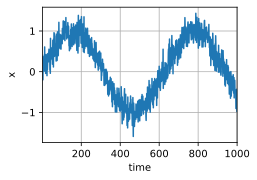

In [3]:
T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01*time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000])

In [8]:
tau = 4
features = torch.zeros((T-tau, tau))
for i in range(tau):
    features[:, i] = x[i:T-tau+i]  # feature的第i列为x的i后面996个数据

labels = x[tau:].reshape((-1, 1))
batch_size, n_train = 16, 600
# 只有前`n_train`个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [17]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss()

In [18]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.051558
epoch 2, loss: 0.045969
epoch 3, loss: 0.045830
epoch 4, loss: 0.048735
epoch 5, loss: 0.052726


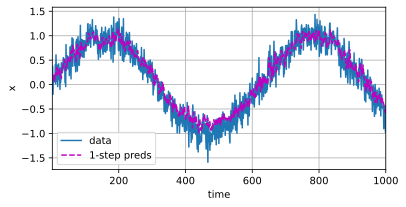

In [19]:
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

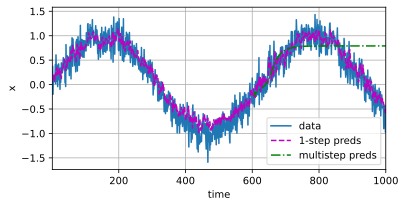

In [20]:
# 使用预测来预测，即多步预测
multistep_preds = torch.zeros(T)
# 前604步使用原始数据
multistep_preds[:n_train+tau] = x[:n_train+tau]
# 604步之后使用过去tau步来预测
for i in range(n_train+tau, T):
    multistep_preds[i] = net(multistep_preds[i-tau:i].reshape((1, -1)))


d2l.plot([time, time[tau:], time[n_train + tau:]], [
    x.detach().numpy(),
    onestep_preds.detach().numpy(),
    multistep_preds[n_train + tau:].detach().numpy()], 'time', 'x',
         legend=['data', '1-step preds',
                 'multistep preds'], xlim=[1, 1000], figsize=(6, 3))

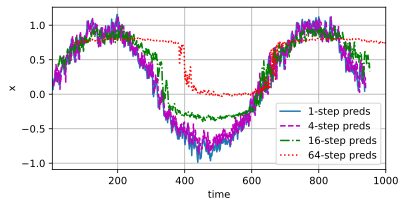

In [24]:
max_steps = 64
features = torch.zeros((T-tau-max_steps+1, tau+max_steps))
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]  # (933, 68)

for i in range(tau, tau + max_steps): # 4-68，即预测第0-64步的结果
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time',
         'x', legend=[f'{i}-step preds'
                      for i in steps], xlim=[5, 1000], figsize=(6, 3))

# 文本预处理

In [2]:
import collections
import re

In [3]:
# 加载数据集
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  #@save
    """Load the time machine dataset into a list of text lines."""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [9]:
def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符标记。"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知令牌类型：' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [18]:
# 构建词表
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # 未知标记的索引为0
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [
            token for token, freq in self.token_freqs
            if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def count_corpus(tokens):  #@save
    """Count token frequencies."""
    # 这里的 `tokens` 是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将令牌列表展平
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)    

In [19]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [20]:
for i in [0, 10]:
    print('words: ', tokens[i])
    print('indices: ', vocab[tokens[i]])

words:  ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices:  [1, 19, 50, 40, 2183, 2184, 400]
words:  ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices:  [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [21]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的令牌索引和词汇表。"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每一个文本行不一定是一个句子或段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

# 语言模型和数据集

In [2]:
tokens = d2l.tokenize(d2l.read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，
# 我们连接所有文本行
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

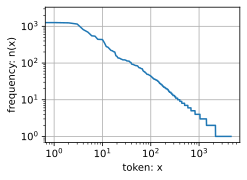

In [3]:
# 词频图
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)', xscale='log',
         yscale='log')

In [4]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [5]:
trigram_tokens = [
    triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

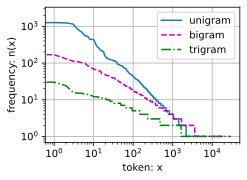

In [6]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

In [7]:
# 随机采样
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一小批子序列。"""
    # 从随机偏移量（包括`num_steps - 1`）开始对序列进行分区
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为`num_steps`的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样中，迭代过程中两个相邻随机小批量的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从`pos`开始的长度为`num_steps`的序列
        return corpus[pos:pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 这里，`initial_indices`包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i:i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [9]:
import random
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[19, 20, 21, 22, 23],
        [ 4,  5,  6,  7,  8]]) 
Y: tensor([[20, 21, 22, 23, 24],
        [ 5,  6,  7,  8,  9]])
X:  tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]]) 
Y: tensor([[15, 16, 17, 18, 19],
        [30, 31, 32, 33, 34]])
X:  tensor([[24, 25, 26, 27, 28],
        [ 9, 10, 11, 12, 13]]) 
Y: tensor([[25, 26, 27, 28, 29],
        [10, 11, 12, 13, 14]])


In [10]:
# 顺序分区
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一小批子序列。"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset:offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1:offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X, Y

In [11]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 5,  6,  7,  8,  9],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[ 6,  7,  8,  9, 10],
        [20, 21, 22, 23, 24]])
X:  tensor([[10, 11, 12, 13, 14],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [25, 26, 27, 28, 29]])


In [12]:
class SeqDataLoader:  #@save
    """加载序列数据的迭代器。"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [13]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表。"""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter,
                              max_tokens)
    return data_iter, data_iter.vocab

# 循环神经网络

In [14]:
X, W_xh = torch.normal(0, 1, (3, 1)), torch.normal(0, 1, (1, 4))
H, W_hh = torch.normal(0, 1, (3, 4)), torch.normal(0, 1, (4, 4))
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[ 0.6906,  0.7407,  1.0271, -1.1754],
        [-2.1963, -0.4141,  0.1227, -0.5719],
        [-2.9003,  1.4980,  2.2247, -2.2696]])

In [15]:
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[ 0.6906,  0.7407,  1.0271, -1.1754],
        [-2.1963, -0.4141,  0.1227, -0.5719],
        [-2.9003,  1.4980,  2.2247, -2.2696]])

# RNN从零实现

In [2]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [3]:
F.one_hot(torch.tensor([0, 2]), len(vocab)) # 将label转换为len(vocab)长度的onehot

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [4]:
# 小批量的形状为(批量，时间步数)
# 我们需要获得(时间步数，批量，词汇大小)的输出
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [5]:
# 初始化模型参数
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    
    return params

In [6]:
# 网络模型
def init_rnn_state(batch_size, num_hiddens, device):
    # 返回的是隐藏状态
    return (torch.zeros((batch_size, num_hiddens), device=device))

In [7]:
def rnn(inputs, state, params):
    # `inputs`的形状：(`时间步数量`, `批量大小`, `词表大小`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H = state
    outputs = []
    # `X`的形状：(`批量大小`, `词表大小`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [8]:
class RNNModel:  #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [ ]:
num_hiddens = 16
net = RNNModel(len(vocab), num_hiddens, 'cpu', get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], 'cpu')
print(state.shape)
Y, new_state = net(X.to('cpu'), state)
Y.shape, len(new_state), new_state[0].shape

In [ ]:
# 输出形状是(时间步数 × 批量大小, 词汇表大小)，而隐藏状态形状保持不变，即(批量大小, 隐藏单元数)。

In [1]:
# 梯度裁剪
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

# 简洁实现

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [3]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [4]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape # (隐藏层，批量，隐藏单元数)

torch.Size([1, 32, 256])

In [7]:
X =  torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [8]:
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        
        if not self.rnn.bidirectional:
            self.num_direction = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_direction = 2
            self.linear = nn.Linear(self.num_hiddens*2, self.vocab_size)
    
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层更改形状为(时间步*批量，隐藏单元)
        # 输出为(时间步*批量，词表大小)
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU
            return torch.zeros((self.num_direction*self.rnn.num_layers, 
                                batch_size, self.num_hiddens), device=device)
        else:
            # nn.LSTM
            return (torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device),
                    torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device))

In [9]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerpipipipipi'

perplexity 1.3, 52971.4 tokens/sec on cpu
time travellerit s against reason said filbycan a full sabdinge 
travelleryon said the time travellerit s againe unt mas a t


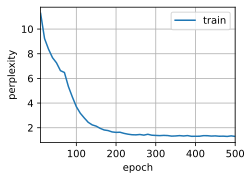

In [10]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)